Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [1]:
from random import random, seed
from itertools import product
import numpy as np
from matplotlib import pyplot as plt

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [2]:
UNIVERSE_SIZE = 1000
NUM_SETS = 200
DENSITY = 0.1

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

- `UNIVERSE_SIZE` is the number of items
- `NUM_SETS` is the total number of sets associated to the universe initially
- `DENSITY` is the probability of each item to belong to each set, or also the total cover of the unisverse by each set

In [3]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

- `SETS` is a `<NUM_SETS x UNIVERSE_SIZE>` vector indicating for each set whether each element of the universe belong to the set or not; `SETS` are randomly generated but in order to ensure UNIVERSE completeness, the loop check if some elements are not present in any set in order to add it to a random one in that case;
- `COSTS` is a `<NUM_SETS>` vector indicating the total cost of each set;

## Helper Functions

In [4]:
def phenotype(solution):
    """Returns the phenotype of the solution"""
    return np.logical_or.reduce(SETS[solution]) # LOGICAL OR OF ALL CHOSEN SETS ITEMS: presence of all items in this solution

def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(phenotype(solution))

def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

A first trivial solution includes all sets in the "*set of subsets*"

In [5]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
ic(solution);
ic(valid(solution), cost(solution));

ic| solution: array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,

Another solution includes half of the sets, but the number of subsets is very high so there is still complete coverage for most cases (maybe all).

In [6]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < 0.5
ic(solution);
ic(valid(solution), cost(solution));

ic| solution: array([False, False,  True,  True,  True, False,  True,  True,  True,
                      True, False, False, False,  True,  True, False, False, False,
                      True,  True, False, False,  True, False, False, False, False,
                      True,  True, False,  True, False, False, False,  True,  True,
                     False, False, False,  True,  True, False,  True,  True, False,
                      True, False,  True, False, False,  True,  True,  True, False,
                      True, False, False,  True,  True,  True, False, False, False,
                      True, False, False,  True,  True, False,  True, False,  True,
                     False,  True, False,  True, False, False, False, False, False,
                     False, False, False,  True,  True, False, False,  True,  True,
                      True, False,  True,  True,  True, False,  True, False, False,
                      True,  True,  True,  True, False, False, False, False,

### Hill Climbing Alg.
We start by using Hill Climbing algorithm, and so we define the *tweaking function*:


In [7]:
def single_mutation_tweak(sol: np.ndarray) -> np.ndarray:
    """tweaks provided solution"""
    new_sol = sol.copy()
    i = rng.integers(0,NUM_SETS) # generate random indexes
    new_sol[i] = not new_sol[i] # flip generate indexes
    return new_sol


In [8]:
def multiple_mutation_tweak(sol: np.ndarray) -> np.ndarray:
    """tweaks provided solution"""
    mask = rng.random(NUM_SETS)<0.01 # flip 1% of sets
    new_sol = np.logical_xor(sol,mask)
    return new_sol

In [9]:
def fitness(solution: np.ndarray):
    return (valid(solution),-cost(solution)) # only step into valid solutions

ic| fitness(solution): (np.True_, np.float64(-13891.250921973355))
ic| fitness(solution): (np.True_, np.float64(-5603.877266316102))


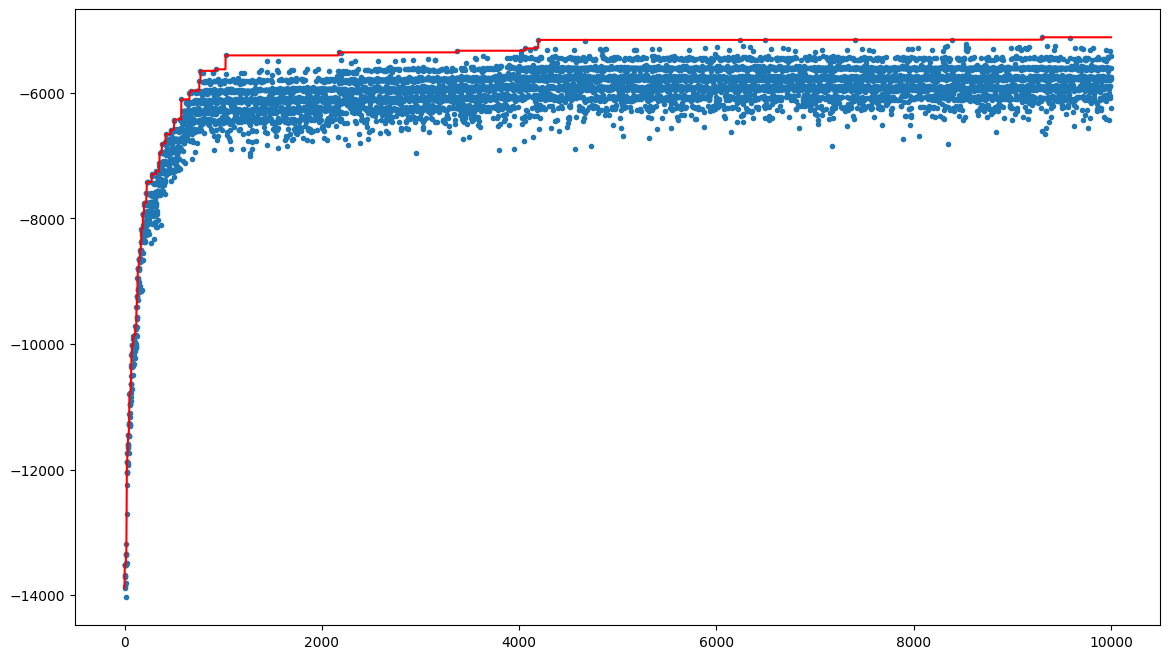

In [10]:
solution = rng.random(NUM_SETS) < .5 # start from a valid solution
ic(fitness(solution))
solution_fitness = fitness(solution)
history = [solution_fitness[1]]
tweak = multiple_mutation_tweak
for steps in range(10_000):
    new_solution = tweak(solution)
    new_fitness = fitness(new_solution)
    history.append(new_fitness[1])
    if new_fitness>solution_fitness:
        solution=new_solution
        solution_fitness = new_fitness
    
ic(fitness(solution))
plt.figure(figsize=(14, 8))
plt.plot(
    [max(history[: i + 1]) for i in range(len(history))],
    color="red",
)
plt.scatter(range(len(history)), history, marker=".");


### Simulated Annealing
Another option is to use a new variable temperature in order to accept worsening solution depening if the temperature is high or not.

In [11]:
def p_temp_swap(t,old_fitness,new_fitness):
    if new_fitness>old_fitness:
        return 1
    else:
        return np.exp(-(old_fitness-new_fitness)/t)

def random_temp_swap(t,old_fitness,new_fitness):
    return rng.random()<p_temp_swap(t,old_fitness,new_fitness)

In this case, i choose to model the temperature as exponentially : the parameter *alpha* is the actual coefficient whose power of *k* iterations is used to perform the cool down.

ic| fitness

(solution): (np.True_, np.float64(-17524.47675956514))
ic| temp: 1000
ic| fitness(solution): (np.True_, np.float64(-5578.642161957856))
ic| temp: 0.045173345977048314


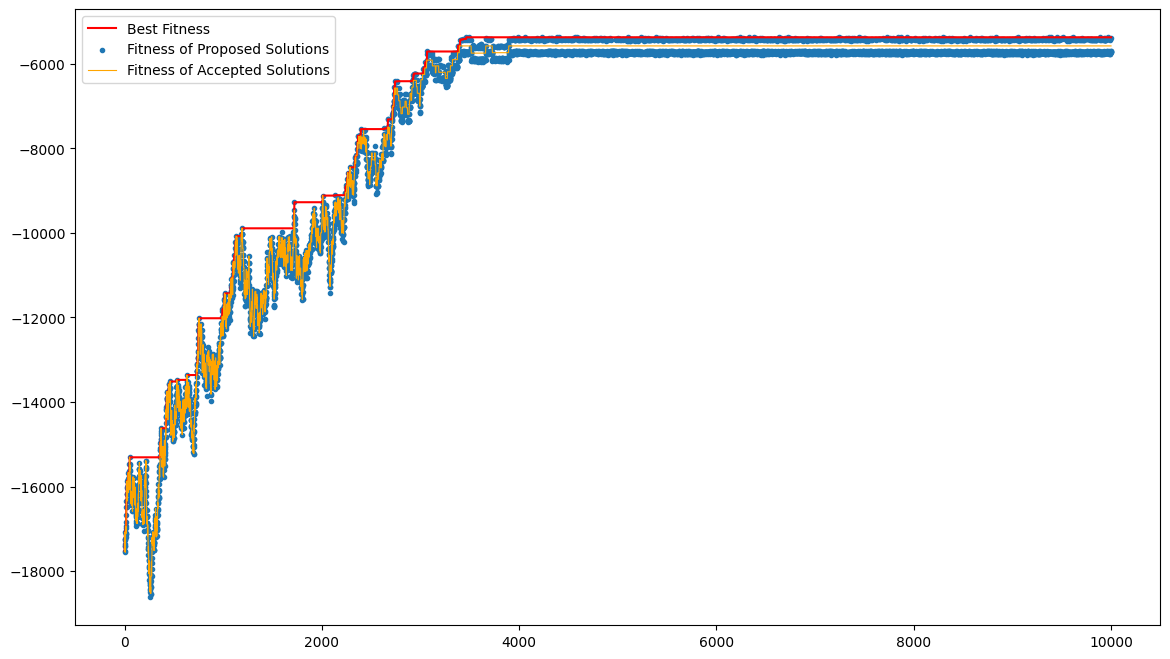

In [41]:
def simulate_annealing():
    temp = 1_000
    ITER = 10_000
    alpha = 0.999


    tweak = single_mutation_tweak
    solution = rng.random(NUM_SETS) < .5 # start from a random solution
    ic(fitness(solution))
    ic(temp)
    solution_fitness = fitness(solution)
    history = [solution_fitness[1]]
    accepted_history = [solution_fitness[1]]
    for k in range(ITER):
        new_solution = tweak(solution)
        new_fitness = fitness(new_solution)
        history.append(new_fitness[1])
        if new_fitness[0] and random_temp_swap(temp,solution_fitness[1],new_fitness[1]):
            solution=new_solution
            solution_fitness = new_fitness
        accepted_history.append(solution_fitness[1])
        temp = temp*alpha
        
    ic(fitness(solution))
    ic(temp)
    plt.figure(figsize=(14, 8))
    plt.plot(
        [max(history[: i + 1]) for i in range(len(history))],
        color="red",
        label='Best Fitness'
    )
    plt.scatter(range(len(history)),history, marker=".",label='Fitness of Proposed Solutions')
    plt.plot(
        accepted_history,
        color="orange",
        linewidth=0.8,
        label='Fitness of Accepted Solutions'
    )
    plt.legend();
simulate_annealing();

As we can see from the plot, the model focuses on **exploitation** when the temperature is high, and as it cools down the model is more focused on **exploitation**.
This technique seems useful, but the risk is to remain stuck in a *plateau* or a *ridge* corresponding to a local maximum, as when the maximum is found much less exploration is done: this can be solved with **iterated local search**, by **restarting** the algorithm at certain points using the previous solutions as starting points: